In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

import gym

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[source](https://www.youtube.com/watch?v=HR8kQMTO8bk) followed for implementation.

In [3]:
# Policy and value model
class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
        )

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

    def forward(self, obs):
        policy_logits = self.policy(obs)
        value = self.value(obs)
        return policy_logits, value



In [4]:
class PPOTrainer():
    def __init__(self,
                 actor_critic,
                 ppo_clip_value=0.2,
                 target_kl_div=0.02, # how far we want to get from the policy before stop doing updates
                 max_policy_train_iters=80, # how much times to update the policy
                 value_train_iters=80,  # how much times to update the value
                 policy_lr=3e-4,
                 value_lr=1e-3):
        self.ac = actor_critic
        self.ppo_clip_value = ppo_clip_value
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters

        policy_params = list(actor_critic.shared_layers.parameters()) + \
            list(actor_critic.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

        value_params = list(actor_critic.shared_layers.parameters()) + \
            list(actor_critic.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=policy_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        for _ in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad()

            new_logits = self.ac.policy(obs)
            new_logits = Categorical(logits=new_logits)
            new_log_probs = new_logits.log_prob(acts)

            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_ratio = policy_ratio.clamp(
                1 - self.ppo_clip_value,
                1 + self.ppo_clip_value)
            clipped_loss = clipped_ratio * gaes
            full_loss = policy_ratio * gaes
            policy_loss = -torch.min(full_loss, clipped_loss).mean()

            policy_loss.backward()
            self.policy_optim.step()
            
            kl_div = (old_log_probs - new_log_probs).mean()

            if kl_div > self.target_kl_div:
                break

    def train_value(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.ac.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()



In [5]:
def rollout(model, env, max_steps=1000):
    '''
    Performs a single rollout.
    Returns training data in the shape (n_steps, obeservation_space)
    and the cumulative reward.
    '''
    ### create data storage
    train_data = [[], [], [], [], []] # obs, act, rew, gaes, act_log_probs
    obs = env.reset()

    ep_reward = 0
    for _ in range(max_steps):
        obs_t = torch.FloatTensor(np.asarray([obs])).to(device)
        logits, val = model(obs_t)
        act_distribution = Categorical(logits=logits)  # 
        act = act_distribution.sample() # sample action index with probabilities following logits distribution
        act_log_prob = act_distribution.log_prob(act).item()

        act, val = act.item(), val.item()
        next_obs, reward, done, _ = env.step(act)


        ## record data for training
        for i, item in enumerate((obs, act, reward, val, act_log_prob)):
            train_data[i].append(item)
        
        obs = next_obs
        ep_reward += reward
        if done:
            break
    


    ## do train data filtering
    train_data[3] = calculate_gaes(train_data[2], train_data[3])

    train_data = [np.asarray(x) for x in train_data]

    return train_data, ep_reward


In [6]:
# utilities
def discount_rewards(rewards, gamma=0.99):
    '''
    Return discounted rewards based on the given rewards and gamma param.
    '''
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i] + gamma * new_rewards[-1]))
    return np.array(new_rewards[::-1])


def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    '''
    Return the General Advantage Estimates from the given rewards and values
    Paper: https://arxiv.org/pdf/1506.02438.pdf
    '''
    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

In [12]:
env = gym.make('CartPole-v0')
model = ActorCriticNetwork(env.observation_space.shape[0], env.action_space.n).to(device)
train_data, reward = rollout(model, env)


In [13]:
# instantiate PPO trainer
ppo_trainer = PPOTrainer(
    model,
    target_kl_div=0.02,
    max_policy_train_iters=40,
    value_train_iters=40,
    policy_lr=3e-4,
    value_lr=1e-3,
)


In [14]:
# training params
n_episodes = 2000
print_freq = 20
target_reward = 190

In [15]:
# training loop
ep_rewards = []
for ep in range(n_episodes):
    # perform rollout
    train_data, reward = rollout(model, env)
    ep_rewards.append(reward)

    # shuffle 
    permute_idxs = np.random.permutation(len(train_data[0]))

    # policy data
    obs = torch.FloatTensor(train_data[0][permute_idxs]).to(device)
    acts = torch.LongTensor(train_data[1][permute_idxs]).to(device)
    gaes = torch.FloatTensor(train_data[3][permute_idxs]).to(device)
    act_log_probs = torch.FloatTensor(train_data[4][permute_idxs]).to(device)

    # value data
    returns = discount_rewards(train_data[2][permute_idxs])
    returns = torch.FloatTensor(returns).to(device)

    # train policy
    ppo_trainer.train_policy(obs, acts, act_log_probs, gaes)

    # train value
    ppo_trainer.train_value(obs, returns)


    avg_rewards = np.mean(ep_rewards[-print_freq:]) if ep >= print_freq else np.mean(ep_rewards)
    # prints
    if (ep + 1) % print_freq ==0:
        print('Episode {} | avg Reward:{:.1f}'.format(ep + 1, avg_rewards))

    
    if avg_rewards >= target_reward:
        print("Environment solved in {} episodes | avg reward: {:.1f}".format(ep + 1, avg_rewards))
        break
       

Episode 20 | avg Reward:16.1
Episode 40 | avg Reward:19.4
Episode 60 | avg Reward:23.7
Episode 80 | avg Reward:82.8
Episode 100 | avg Reward:74.9
Episode 120 | avg Reward:154.6
Environment solved in 136 episodes | avg reward: 190.3


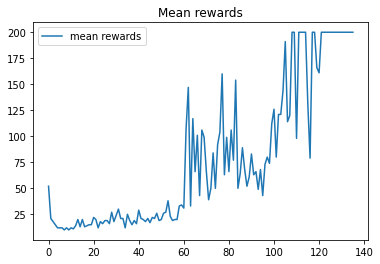

In [18]:
import matplotlib.pyplot as plt
plt.plot(ep_rewards, label='mean rewards')
plt.legend(loc='best')
plt.title("Mean rewards")
plt.show()